In [172]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [107]:
# with open("data/user_dict.pkl", "rb") as infile:
#     user_data = pickle.load(infile)

ratings = pd.read_csv("data/all_recipe_clean.csv")

In [17]:
print("Ratings Data")
print("Number of Ratings: {}".format(len(ratings)))
print("Number of Recipes: {}".format(len(ratings.recipe_id.value_counts())))
print("Number of Users: {}".format(len(ratings.user_id.value_counts())))
print("Average Rating: {0:.3f}".format(ratings.rating.mean()))

# ratings

Ratings Data
Number of Ratings: 162671
Number of Recipes: 3913
Number of Users: 87786
Average Rating: 4.498


Text(0.5, 0, 'Rating')

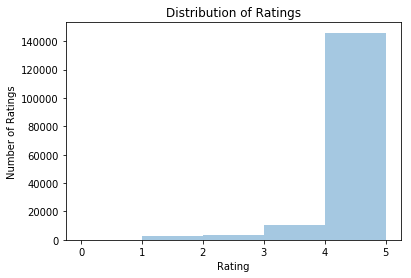

In [33]:
# TODO: Distribution of recipe ratings
# ratings.recipe_id.value_counts()

#TODO: Distribution of user ratings


# Distribution of Ratings
rating_values = ratings.rating.values
bins = bins=np.arange(rating_values.min(), rating_values.max() + 1)
ax = sns.distplot(rating_values, kde=False, bins=bins)
ax.set_title("Distribution of Ratings")
ax.set_ylabel("Number of Ratings")
ax.set_xlabel("Rating")

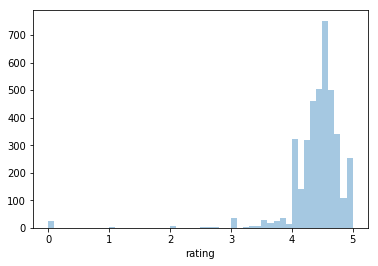

In [108]:
recipe_ratings = ratings.groupby("recipe_id").rating.mean()
ax = sns.distplot(recipe_ratings, kde=False)

Text(0.5, 0, 'Number of Ratings given to Recipe')

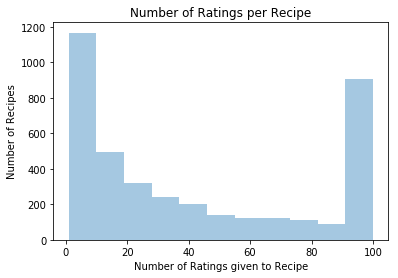

In [39]:
# Ratings counts
ax = sns.distplot(ratings.recipe_id.value_counts().values, kde=False)
ax.set_title("Number of Ratings per Recipe")
ax.set_ylabel("Number of Recipes")
ax.set_xlabel("Number of Ratings given to Recipe")

Text(0, 0.5, 'Recipe Count')

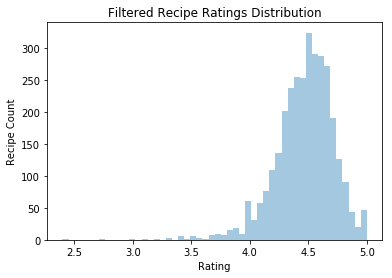

In [111]:
# User Ratings
# ax = sns.distplot(ratings.user_id.value_counts().values, kde=False)
# ax = sns.boxplot(x=ratings.user_id.value_counts().values)
# print("Number of ratings per user")
# ratings.user_id.value_counts().describe()

recipe_ratings = ratings_filtered.groupby("recipe_id").rating.mean().values
ax = sns.distplot(recipe_ratings, kde=False)
ax.set_title("Filtered Recipe Ratings Distribution")
ax.set_xlabel("Rating")
ax.set_ylabel("Recipe Count")

In [160]:
# user_rating_counts = ratings.user_id.value_counts()
# user_rating_counts = user_rating_counts[user_rating_counts >= 3]

# train_users, test_users = train_test_split(ratings.user_id.unique(), test_size=0.2, random_state=0)

# ratings.user_id.unique()
# test_users.shape
# 
# user_rating_counts[user_rating_counts >= 3].index.unique().values

# np.sum(ratings.recipe_id.value_counts() >= 5)

recipe_rating_counts = ratings.recipe_id.value_counts()
recipe_ids = recipe_rating_counts[recipe_rating_counts >= 5].index.unique().values
recipe_ids = frozenset(recipe_ids)
ratings_filtered = ratings[ratings.recipe_id.isin(recipe_ids)]

# ratings_filtered = ratings[ratings.user_id.isin(frozenset(train_users))]

# ratings_filtered.groupby("recipe_id").user_id.apply(np.array)

# ratings_filtered.groupby("user_id").recipe_id.apply(set)

recipe_id
0       [17996, 83450, 66642, 36626, 67616, 41640, 349...
1       [75486, 82861, 51605, 17536, 10438, 71731, 241...
2       [33811, 48434, 75221, 82269, 29354, 43795, 707...
3       [78169, 1681, 10291, 33621, 64075, 86405, 8262...
4       [28046, 30610, 25697, 33811, 41963, 82522, 448...
5                     [39678, 76277, 57673, 86883, 61282]
7       [78218, 54600, 80938, 30832, 46395, 49031, 493...
8              [38919, 62643, 83368, 43681, 19215, 79908]
10      [69975, 34575, 12958, 68776, 14960, 1368, 7461...
11      [20482, 1852, 34491, 31134, 67876, 15022, 5259...
12      [1120, 22744, 79533, 76793, 41370, 47721, 1904...
13      [19841, 4744, 71710, 85034, 56304, 77948, 7273...
14        [85510, 1282, 30074, 71699, 9215, 44647, 35220]
15      [49480, 13334, 76337, 8366, 67819, 73977, 6864...
16      [44537, 1899, 84540, 42861, 47634, 68086, 4520...
17      [43679, 15618, 73723, 49474, 75414, 67580, 102...
18      [57366, 45783, 36843, 6378, 81471, 19811, 1968...
19  

In [132]:
# ratings_filtered[ratings_filtered.recipe_id == 5].user_id
# ratings_dict = ratings_filtered.groupby(["user_id", "recipe_id"]).rating.apply(sum)

ratings_dict[8][194]

4

In [302]:
# Segment Data (TODO: Move into class)
class DataLoader:
    """
    ratings: Dataframe of recipe ratings by user id.
    min_recipe_ratings: int the minimum number of ratings a recipe should have
        to be included.
    min_user_ratings: int the minimum number of ratings a user must have to be
        used for training/testing. Should be at least 2.
    random_state: integer indicating the random state to use for splits
    """
    def __init__(self, ratings, min_recipe_ratings=5, min_user_ratings=3, random_state=0):
        self.random_state = random_state
        
        # Filter recipes to have at least min_recipe_ratings
        recipe_rating_counts = ratings.recipe_id.value_counts()
        recipe_ids = recipe_rating_counts[recipe_rating_counts >= min_recipe_ratings].index.unique().values
        recipe_ids = frozenset(recipe_ids)
        ratings = ratings[ratings.recipe_id.isin(recipe_ids)]
        
        # Map from users to recipes to ratings
        # ex. all_ratings[user_id][recipe_id] returns the user's rating for the recipe
        self.all_ratings = self.ratings_group_to_dict(ratings.groupby(["user_id", "recipe_id"]).rating.apply(sum))
        
        # Select users who'll be used for training/testing 
        user_rating_counts = ratings.user_id.value_counts()
        eval_users = user_rating_counts[user_rating_counts >= min_user_ratings].index.unique().values
        train_users, test_users = train_test_split(
            eval_users, test_size=0.1, random_state=random_state)
    
        self.train_users = train_users
        self.test_users = test_users
    
        # Only those ratings made by users in the training set
        ratings_train_users = ratings[ratings.user_id.isin(frozenset(train_users))]
        
        # Ratings made by users in training set and users with < min_recipe_ratings ratings
        # Maps from recipe_id to user_id to rating
        # train_ratings[user_id][recipe_id]
        train_only_ratings = ratings[~ratings.user_id.isin(frozenset(test_users))]
        self.train_ratings = train_only_ratings.groupby(["user_id", "recipe_id"]).rating.apply(sum)
        
        # Only those ratings made by users in the test set
        ratings_test_users = ratings[ratings.user_id.isin(frozenset(test_users))]
    
        # Map from recipes to the user_ids of those who rated them (including low-rating users)
        self.recipe_to_raters_train = train_only_ratings.groupby("recipe_id").user_id.apply(frozenset)
        self.user_to_recipes_train = ratings_train_users.groupby("user_id").recipe_id.apply(frozenset)
        # Include all users, including test users
        self.recipe_to_raters_test = ratings.groupby("recipe_id").user_id.apply(frozenset)
        # TODO: correct split?
        self.user_to_recipes_test = ratings_test_users.groupby("user_id").recipe_id.apply(frozenset)
        
    def get_holdout_data(self, split="train"):
#         users = self.user_to_recipes_train
#         ratings = self.train_ratings
        
        if split == "train":
            users = self.train_users
        elif split == "test":
            users = self.test_users
        else:
            raise ValueError("Unexpected split: {}".format(split))
        
        # List
        np.random.seed(self.random_state)
        holdout = []
        # Note: user_to_recipes excludes users with < min_user_ratings
#         user_to_recipes_no_holdout = defaultdict(dict)
        
        user_holdout = {}
        recipe_heldout_users = defaultdict(set)
        for user_id in users:
#             np.random.choice(np.fromiter(d.keys(), dtype=np.int64))
            user_recipes = self.all_ratings[user_id].keys()
            hidden_recipe_id = np.random.choice(np.fromiter(user_recipes, dtype=np.int64))
            
            user_holdout[user_id] = hidden_recipe_id
            recipe_heldout_users[hidden_recipe_id].add(user_id)
            
            user_rating = self.all_ratings[user_id][hidden_recipe_id]
            holdout.append((user_id, hidden_recipe_id, user_rating))
#             user_to_recipes_no_holdout[user_id] = {k: v for k, v in ratings[user_id].items() if k != hidden_recipe_id}
        
        # This includes users with < min_user_ratings. Use it to calculate the ratings
#         recipe_to_raters_no_holdout = defaultdict(dict)
#         for recipe_id, user_ratings in ratings.items():
#             recipe_to_raters_no_holdout[recipe_id] = \
#                 {user for user in user_ratings if user not in recipe_heldout_users[recipe_id]}
        
        # TODO: We don't need the more aggressive holdout techniques on the test set, only on the train set
#         return users_to_recipe_not_holdout, recipe_to_raters_no_holdout, holdout
        return user_holdout, recipe_heldout_users, holdout
        
    def get_user_ratings(self, user_id, user_holdout):
        """
        For a given user, return a dictionary mapping from recipe ids to the user's rating,
        excluding the recipe in the holdout for that user.
        user_holdout: dict mapping from user_id to the recipe_id of the heldout recipe
        """
        heldout_recipe_id = user_holdout[user_id]
        return {recipe_id: rating for recipe_id, rating in self.all_ratings[user_id].items() if recipe_id != heldout_recipe_id}
    
    def get_recipe_ratings(self, recipe_id, recipe_holdout, split="train"):
        """
        For a given recipe, get a dictionary mapping from user_ids to the user's rating on that recipe,
        excluding any users in the holdout set for that recipe.
        recipe_holdout: dict mapping from recipe_id to a set of user_ids that are in the holdout set for that recipe
        """     
        if split == "train":
            recipe_to_raters = self.recipe_to_raters_train
        elif split == "test":
            recipe_to_raters = self.recipe_to_raters_test
        else:
            raise ValueError("Unexpected split: {}".format(split))
        
        heldout_user_ids = recipe_holdout[recipe_id]
        raters = recipe_to_raters[recipe_id] - heldout_user_ids
        return {user_id: self.all_ratings[user_id][recipe_id] for user_id in raters}
    
    def ratings_group_to_dict(self, df):
        ratings_dict = defaultdict(dict)
        for k, rating in df.items():
            user_id, recipe_id = k
            ratings_dict[user_id][recipe_id] = rating
        return ratings_dict

In [303]:
dataLoader = DataLoader(ratings)
user_holdout, recipe_holdout, holdout = dataLoader.get_holdout_data()
# for user_id, user_recipes in dataLoader.user_to_recipes_train.items():
# #     print(user_id, user_recipes)
#     hidden_recipe_id = np.random.choice(user_recipes)
#     print(hidden_recipe_id)

# dataLoader.all_ratings[4]

In [299]:
# dataLoader.get_user_ratings(4, user_holdout)
dataLoader.get_recipe_ratings(2843, recipe_holdout)
# r2r = dataLoader.recipe_to_raters_train
# huid = recipe_holdout[2843]
# raters = r2r[2843]

# for uid in raters:
#     print(uid)
#     print(dataLoader.all_ratings[uid][2843])
#     print(uid, dataLoader.all_ratings[uid][2843])
#     print(uid, dataLoader.all_ratings[uid])
# dataLoader.recipe_to_raters_train

# r2r = ratings[~ratings.user_id.isin(frozenset(dataLoader.test_users))].groupby("recipe_id").user_id.apply(list)

# recipe_holdout[2843]

# {user_id : {k[1]: rating for recipe_id, rating in v.items()} for k, rating in dataLoader.all_ratings.items()}

# ratings_dict = defaultdict(dict)
# for k, rating in dataLoader.all_ratings.items():
#     user_id, recipe_id = k
#     ratings_dict[user_id][recipe_id] = rating

# dataLoader.all_ratings

# for user_id, recipe_id, rating in holdout:
# #     print(recipe_id, len(dataLoader.get_recipe_ratings(recipe_id, recipe_holdout)))
#     if len(dataLoader.get_recipe_ratings(recipe_id, recipe_holdout)) == 0:
#         print(recipe_id)

{27140: 2,
 50693: 5,
 4: 5,
 44551: 5,
 36360: 5,
 17420: 4,
 31247: 5,
 64017: 4,
 8738: 5,
 33328: 4,
 34866: 1,
 58943: 5,
 36417: 5,
 38984: 5,
 33383: 5,
 7272: 4,
 36459: 3,
 25709: 5,
 28790: 5,
 73335: 5,
 2685: 5,
 41603: 5,
 85637: 5,
 16018: 5,
 53403: 4,
 5287: 5,
 16563: 3,
 39605: 5,
 82110: 5,
 39616: 5,
 7361: 5,
 63686: 4,
 38115: 5,
 28395: 5,
 73967: 4,
 59632: 5,
 4336: 5,
 61168: 5,
 65780: 5,
 251: 3,
 78590: 4,
 5890: 5,
 27395: 5,
 11012: 5,
 65797: 4,
 32520: 5,
 52489: 5,
 39189: 5,
 42274: 5,
 59683: 4,
 55076: 5,
 8485: 1,
 77095: 4,
 85288: 3,
 48423: 5,
 70447: 5,
 63281: 5,
 20792: 5,
 52031: 5,
 37187: 4,
 18254: 4,
 13136: 5,
 54098: 5,
 83294: 4,
 24415: 5,
 79208: 4,
 44393: 5,
 30574: 5,
 73592: 1,
 2424: 5,
 6027: 5,
 87436: 5,
 20363: 4,
 64916: 4,
 27038: 5,
 67497: 4,
 41903: 5,
 13231: 5,
 55245: 5,
 19410: 5,
 24020: 5,
 27606: 5,
 13786: 4,
 62943: 4,
 49639: 5,
 71659: 4,
 87031: 5,
 19455: 3}